In [60]:
import pandas as pd
import yfinance
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import numpy as np

def rmse(pred, actual):
    diffs = pred - actual
    return math.sqrt(np.mean(diffs**2))

tesla_frame = np.log(yfinance.Ticker('TSLA').history(start='2015-01-01', end='2022-01-01', interval='1d') \
    .reset_index()['Close'].to_frame())

plt.rcParams['figure.figsize'] = [16, 8]
series = tesla_frame['Close']

# AR MODEL
ar_deg = 4
model = sm.tsa.AutoReg(tesla_frame, lags=ar_deg, trend='n').fit()

# AR COEFFS
ar_coefs = model.params[::-1]

# Get predictions from AR model
prediction = model.predict()

# convert predictions to a series
tesla_frame['Prediction'] = prediction

# get rmse for ar(4)
ar_rmse = rmse(tesla_frame['Prediction'], tesla_frame['Close'])

# get errors squared
errors = (series - prediction)**2
# remove nan from error sq => change to 0's
errors[errors.isna()] = 0




## Start Monte Carlo Stuffs
```num_samples``` = number of trajectories  

```initial_len``` = is the common points before start to diverge the new predicted trajectories



### MC method - create trajectories and errors

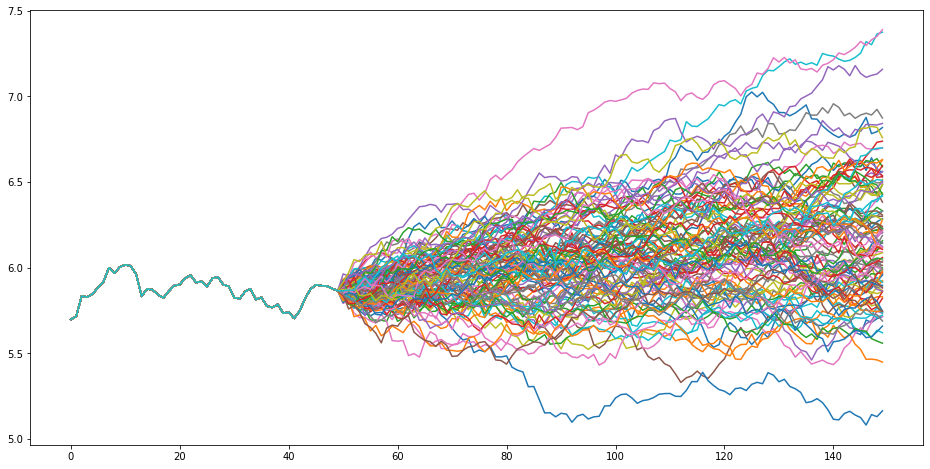

In [61]:
def mc_ar(initial_length, traj_length, num_samples, coefs, rmse, errors, ar_deg):
    # 2D array - (initial len) x (num_samples) 
    trajectories = np.broadcast_to(series.to_numpy()[ -initial_length : ].reshape( (-1,1) ), (initial_length, num_samples))
    
    # Same Thing 2D array (initial len x num samples)
    errors_sq = np.broadcast_to(errors.to_numpy() [-initial_length : ].reshape( (-1, 1) ), (initial_length, num_samples))

    for i in range(traj_length):
        # dot product of ar_coefs and trajectories - same as normal MC
        prediction = coefs @ trajectories[ -ar_deg : , :]

        # guessing next error by multiplying rmse by random normal dist number
        # normal dist: mean = 0, stand dev = 1
        next_error = rmse * np.random.randn(num_samples)

        # create next row
        next_row = prediction + next_error

        # add row to trajectories
        trajectories = np.append( trajectories, next_row.reshape( (1, num_samples) ), axis=0 )

        # add next error to error_sq 
        # print(errors_sq, next_error**2)
        # errors_sq = np.append( errors_sq, (next_error ** 2).reshape( (1, num_samples) ), axis=0 )

    return trajectories, errors_sq

traj1, errors_sq1 = mc_ar(50, 100, 100, ar_coefs, ar_rmse, errors, ar_deg)

_=plt.plot(traj1)


## MC with ARCH and AR

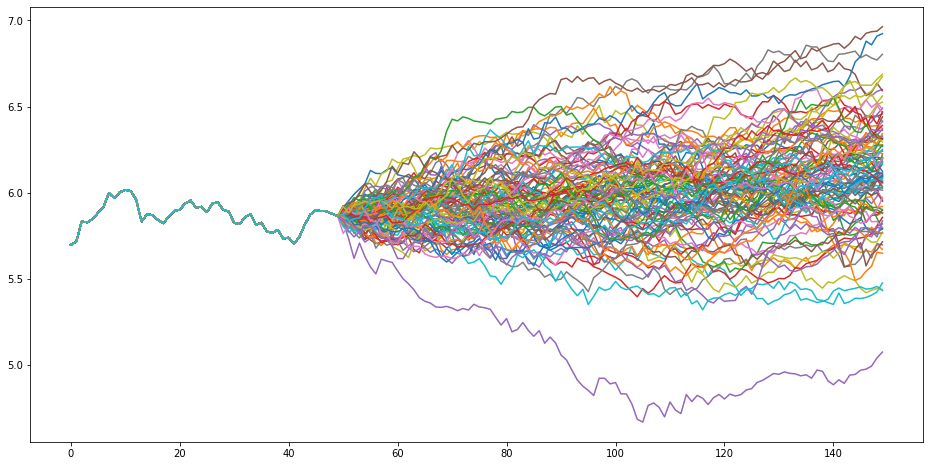

In [68]:
def mc_arch(initial_length, traj_length, num_samples, coefs, rmse, errors, ar_deg, arch_deg):
    # RUN ARCH MODEL ON ERRORS
    arch_model = sm.tsa.AutoReg(errors, lags=arch_deg, trend='c').fit()
    error_pred = np.sqrt(arch_model.predict())
    # GET ARCH COEFFS AND CONSTANT
    arch_coefs = arch_model.params[:0:-1]
    arch_const = arch_model.params[0]

    # 2D array - (initial len) x (num_samples) 
    trajectories = np.broadcast_to(series.to_numpy()[ -initial_length : ].reshape( (-1,1) ), (initial_length, num_samples))
    
    # Same Thing 2D array (initial len x num samples)
    errors_sq = np.broadcast_to(errors.to_numpy() [-initial_length : ].reshape( (-1, 1) ), (initial_length, num_samples))

    for i in range(traj_length):
        # dot product of ar_coefs and trajectories - same as normal MC
        prediction = coefs @ trajectories[ -ar_deg : , :]

        # new bit, predicting errors
        # instead of RMSE * random number from random normal dist
        # use error predictions as well from the arch model
        
        # predicted error = dot product of arch coefs and last however many error squared + a bias
        predicted_errors = arch_const + arch_coefs @ errors_sq[-arch_deg : , : ]

        # NEXT ERROR =  predicted error * random norm dist number
        next_error = np.sqrt(predicted_errors) * np.random.randn(num_samples)

        # create next row
        next_row = prediction + next_error

        # add row to trajectories
        trajectories = np.append( trajectories, next_row.reshape( (1, num_samples) ), axis=0 )

        # add next error to error_sq 
        # print(errors_sq, next_error**2)
        errors_sq = np.append( errors_sq, (next_error ** 2).reshape( (1, num_samples) ), axis=0 )

    return trajectories, errors_sq

traj_arch, errors_sq_arch = mc_arch(50, 100, 100, ar_coefs, ar_rmse, errors, ar_deg, 5)

_=plt.plot(traj_arch)



In [70]:
# make new frame of the error squared and prediction
# tesla_errorsq_frame = pd.DataFrame(columns = ['Err_sq','Pred_Err_sq'])
# tesla_errorsq_frame ['Err_sq']= errors
# tesla_errorsq_frame['Pred_ARCH_mc_Err_sq'] = errors_sq_arch
# tesla_errorsq_frame['Pred_mc_Err_sq'] = errors_sq1
# tesla_errorsq_frame.plot()